# continue doing train test split,preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%run /Users/yaoyao/Documents/datascience/toolbox/toolbox1_dataview.ipynb
%matplotlib inline

## load processed data

In [2]:
with open('raw_y.csv') as f:
    raw_y = pd.read_csv(f)

In [3]:
with open('train_ready.csv') as f:
    train_ready = pd.read_csv(f)

In [6]:
with open('test.csv') as f:
    raw_test = pd.read_csv(f)

In [252]:
def get_accuracy(raw_y):
    # note here, if a session didn't reach the end, we don't have the session here. need to addback in the end
    results = raw_y[(raw_y['title'] == 'Bird Measurer (Assessment)') & (raw_y['event_code'] == 4110)]
    results = results.append(raw_y[(raw_y['title'] != 'Bird Measurer (Assessment)') & (raw_y['event_code'] == 4100)])
    atmp = results.event_data.str.extract(r'("correct"):(\w+)')
    results.insert(6,'attempts',atmp.loc[:,1])
    mapping={"true":1,"false":0}
    results['atmp_binary'] = results['attempts'].map(mapping)
    opt = results.groupby('installation_id').mean()
    opt['acgroup'] = 1
    opt.loc[opt[abs(opt['atmp_binary'] - 0.5) < 1e-9].index,'acgroup'] = 2
    opt.loc[opt[abs(opt['atmp_binary'] - 1) < 1e-9].index,'acgroup'] = 3
    opt.loc[opt[abs(opt['atmp_binary'] - 0) < 1e-9].index,'acgroup'] = 0
    
    #build y
    opty = pd.merge(pd.DataFrame(index = raw_y['installation_id'].unique()).reset_index(),
                    opt.loc[:,['acgroup','atmp_binary']],how='outer',left_on='index',right_on='installation_id').fillna(0)
    opty = opty.rename(columns={'index':'installation_id'})
    opty['acgroup'] = opty.acgroup.astype(int)
    
    return results, opt, opty





In [253]:
y_ready,opt, opty = get_accuracy(raw_y)

In [310]:
def get_acbiny(records):
    
    #this code is used to get accuracy group from the raw records
    results = records[(records['title'] == 'Bird Measurer (Assessment)') & (records['event_code'] == 4110)]
    results = results.append(records[(records['title'] != 'Bird Measurer (Assessment)') & (records['event_code'] == 4100)])
    atmp = results.event_data.str.extract(r'("correct"):(\w+)')
    results.insert(1,'attempts',atmp.loc[:,1])
    mapping={"true":1,"false":0}
    results['atmp_binary'] = results['attempts'].map(mapping)
    return results


In [311]:
train_ready_more = get_acbiny(train_ready[train_ready['type'] == 'Assessment'])

In [258]:
def get_acgroup(records):
    
    #this code is used to get accuracy group from the raw records
    results = records[(records['title'] == 'Bird Measurer (Assessment)') & (records['event_code'] == 4110)]
    results = results.append(records[(records['title'] != 'Bird Measurer (Assessment)') & (records['event_code'] == 4100)])
    atmp = results.event_data.str.extract(r'("correct"):(\w+)')
    results.insert(1,'attempts',atmp.loc[:,1])
    mapping={"true":1,"false":0}
    results['atmp_binary'] = results['attempts'].map(mapping)
    opt = results.groupby('installation_id').mean()
    #opt['acgroup'] = 1
    #opt.loc[opt[abs(opt['atmp_binary'] - 0.5) < 1e-9].index,'acgroup'] = 2
    #opt.loc[opt[abs(opt['atmp_binary'] - 1) < 1e-9].index,'acgroup'] = 3
    #opt.loc[opt[abs(opt['atmp_binary'] - 0) < 1e-9].index,'acgroup'] = 0
    
    #note if the kid didn't finish the game, should return 0
    if len(opt.atmp_binary.values) != 0:
        return opt.atmp_binary.values[0]
    else:
        return 0

In [259]:
def construct_train(train_ready,opty):
    # now we have accuracy group for all installation_id
    # start filling in other information
    #1, whether played same assessment before? if yes, assign times
    opty['pre_count'] = 0
    opty['pre_acbi_mean'] = np.nan
    inputdata = train_ready.loc[:,['installation_id','game_session','title','event_code','event_data']]
    first = 0
    for device in inputdata['installation_id'].unique():
        first += 1
        sample = inputdata[inputdata['installation_id'] == device]
        count = sample[sample['title'] == sample.iloc[-1].title].iloc[:-1].groupby('game_session').count().shape[0]
        opty.loc[opty[opty['installation_id'] == device].index,'pre_count'] = count
        #2, if played before, what is the acgroup?
        if count != 0:
            temp1 = sample[sample['title'] == sample.iloc[-1].title].iloc[:-1]
            opty.loc[opty[opty['installation_id'] == device].index,'pre_acbi_mean'] = get_acgroup(temp1)
        if first % 100 == 0:
            print("processed",first,"ids")
    #merge titles
    #opty = pd.merge(opty,train_ready.drop_duplicates(subset='installation_id',keep='last').loc[:,['installation_id','title']],how='inner',on='installation_id')
    return opty
        

In [264]:
opty_2 = construct_train(train_ready,opty)

processed 100 ids
processed 200 ids
processed 300 ids
processed 400 ids
processed 500 ids
processed 600 ids
processed 700 ids
processed 800 ids
processed 900 ids
processed 1000 ids
processed 1100 ids
processed 1200 ids
processed 1300 ids
processed 1400 ids
processed 1500 ids
processed 1600 ids
processed 1700 ids
processed 1800 ids
processed 1900 ids
processed 2000 ids
processed 2100 ids
processed 2200 ids
processed 2300 ids
processed 2400 ids
processed 2500 ids
processed 2600 ids
processed 2700 ids
processed 2800 ids
processed 2900 ids
processed 3000 ids
processed 3100 ids
processed 3200 ids
processed 3300 ids
processed 3400 ids
processed 3500 ids
processed 3600 ids
processed 3700 ids
processed 3800 ids
processed 3900 ids
processed 4000 ids
processed 4100 ids
processed 4200 ids


In [365]:
# add more training inputs
def construct_train2(train_ready_more,pre_opt):
    df = train_ready_more.groupby('installation_id').mean().atmp_binary.to_frame().reset_index()
    af_opt = pd.merge(pre_opt,df,how='left',on='installation_id')
    
    df2 = train_ready_more.groupby(['installation_id','game_session'])['event_id'].count().groupby('installation_id').count().to_frame()
    af_opt = pd.merge(af_opt,df2,how='left',on='installation_id')
    
    df3 = train_ready_more.groupby(['installation_id','game_session'])['event_count'].mean().to_frame().reset_index().groupby('installation_id').mean().reset_index()
    af_opt = pd.merge(af_opt,df3,how='left',on='installation_id')
    
    df4 = train_ready_more.groupby(['installation_id','game_session'])['game_time'].mean().to_frame().reset_index().groupby('installation_id').mean().reset_index()     
    af_opt = pd.merge(af_opt,df4,how='left',on='installation_id')
    
    df5 = train_ready_more.groupby(['installation_id','game_session'])['game_time'].max().to_frame().reset_index().groupby('installation_id').mean().reset_index()
    df5.rename(columns={'game_time':'pre_gtime_maxmean'},inplace=True)
    af_opt = pd.merge(af_opt,df5,how='left',on='installation_id')
    
    df6 = train_ready_more.groupby(['installation_id','game_session'])['game_time'].min().to_frame().reset_index().groupby('installation_id').mean().reset_index()
    df6.rename(columns={'game_time':'pre_gtime_minmean'},inplace=True)
    af_opt = pd.merge(af_opt,df6,how='left',on='installation_id')
    
    df7 = train_ready_more.groupby(['installation_id','game_session'])['event_count'].max().to_frame().reset_index().groupby('installation_id').mean().reset_index()
    df7.rename(columns={'event_count':'pre_evcount_maxmean'},inplace=True)
    af_opt = pd.merge(af_opt,df7,how='left',on='installation_id')
    
    df8 = train_ready_more.groupby(['installation_id','game_session'])['event_count'].min().to_frame().reset_index().groupby('installation_id').mean().reset_index()
    df8.rename(columns={'event_count':'pre_evcount_minmean'},inplace=True)
    af_opt = pd.merge(af_opt,df8,how='left',on='installation_id')
    
    af_opt.rename(columns={'atmp_binary_y':'preall_acbi_mean',
                           'event_id':'num_as_played',
                           'event_count':'pre_evcount_mean',
                           'game_time':'pre_gtime_mean'},inplace=True)
    return af_opt
    

In [366]:
newopt = construct_train2(train_ready_more,opty_2)
newopt.head()

,installation_id,acgroup,atmp_binary_x,pre_count,pre_acbi_mean,preall_acbi_mean,num_as_played,pre_evcount_mean,pre_gtime_mean,pre_gtime_maxmean,pre_gtime_minmean,pre_evcount_maxmean,pre_evcount_minmean
0,0006a69f,3,1.0,1,0.0,0.200000,4.0,40.602273,32477.056818,40528.00,25823.0,49.25,33.00
1,0006c192,2,0.5,0,NaN,0.200000,2.0,45.000000,32004.125000,46313.50,22511.5,62.50,31.50
2,00129856,3,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001d0ed0,0,0.0,0,NaN,0.333333,4.0,28.000000,25089.000000,32213.75,19471.0,36.50,21.75
4,00225f67,0,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


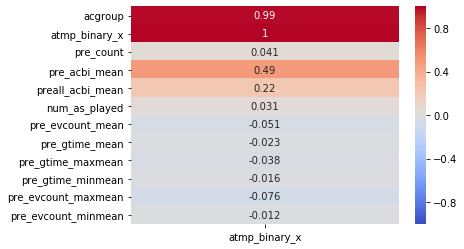

In [367]:
sns.heatmap(newopt.corr()[['atmp_binary_x']],vmin=-1,cmap='coolwarm',xticklabels=True, yticklabels=True,annot=True)

# model training

In [370]:
from xgboost import XGBRegressor
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MultiLabelBinarizer

In [373]:
raw_x = newopt.drop(columns=['acgroup','atmp_binary_x','installation_id'])
raw_y = newopt['acgroup']

In [374]:
raw_x.head()
raw_y.head()

,pre_count,pre_acbi_mean,preall_acbi_mean,num_as_played,pre_evcount_mean,pre_gtime_mean,pre_gtime_maxmean,pre_gtime_minmean,pre_evcount_maxmean,pre_evcount_minmean
0,1,0.0,0.200000,4.0,40.602273,32477.056818,40528.00,25823.0,49.25,33.00
1,0,NaN,0.200000,2.0,45.000000,32004.125000,46313.50,22511.5,62.50,31.50
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,NaN,0.333333,4.0,28.000000,25089.000000,32213.75,19471.0,36.50,21.75
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0    3
1    2
2    3
3    0
4    0
Name: acgroup, dtype: int64

In [387]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

In [391]:
#pl_random_forest = Pipeline(steps=[('random_forest', RandomForestClassifier())])
pl_random_forest = Pipeline(steps=[('random_forest', XGBClassifier(max_depth=5,l))])
scores = cross_val_score(pl_random_forest, raw_x, raw_y, cv=10,scoring='accuracy')
print('Accuracy for RandomForest : ', scores.mean())

Accuracy for RandomForest :  0.5374969719794016
